<a href="https://colab.research.google.com/github/TUIlmenauAMS/ADSP_Tutorials/blob/master/predictiveDenoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive-filter denoising (LPC + LMS) in the time domain

This notebook:
- Loads an audio signal from a file
- Adds noise with a controlled target SNR
- Denoises using **predictive filters**:
  - **Blockwise LPC (linear prediction)**
  - **Adaptive LMS predictor**
- Compares waveforms, spectrograms, and SNR

Core idea: many audio signals (esp. speech) are predictable short-term, while (white) noise is not. A predictor can track the predictable part and suppress the unpredictable part.


In [1]:
!pip -q install librosa soundfile

import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from IPython.display import Audio, display

np.random.seed(0)

## 1) Upload & load audio

Upload any audio file (wav/flac/mp3/ogg). We'll convert to mono and optionally resample.


In [13]:
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded.keys()))
print('Loaded:', path)

# Target sample rate (set to None to keep original)
TARGET_SR = 16000

x, sr = librosa.load(path, sr=TARGET_SR, mono=True)
x = x.astype(np.float32)
x = x / (np.max(np.abs(x)) + 1e-12)  # normalize to [-1,1]
print('sr =', sr, '| length =', len(x)/sr, 'seconds')

display(Audio(x, rate=sr))

Saving mspeech.wav to mspeech.wav
Loaded: mspeech.wav
sr = 16000 | length = 16.8746875 seconds


## 2) Add noise at a target SNR

We create a noisy signal `y = x + n` where `n` is Gaussian white noise scaled to achieve a desired SNR (in dB).


In [14]:
def rms(sig: np.ndarray) -> float:
    return float(np.sqrt(np.mean(sig**2) + 1e-12))

def snr_db(clean: np.ndarray, test: np.ndarray) -> float:
    # SNR between clean and (clean+error) = clean vs error
    e = test - clean
    return 20*np.log10(rms(clean) / (rms(e) + 1e-12) + 1e-12)

def add_awgn_at_snr(clean: np.ndarray, snr_target_db: float) -> np.ndarray:
    n = np.random.randn(*clean.shape).astype(np.float32)
    # scale noise to meet target SNR: SNR = 20log10(rms(clean)/rms(noise))
    noise_rms_needed = rms(clean) / (10**(snr_target_db/20))
    n = n * (noise_rms_needed / (rms(n) + 1e-12))
    return clean + n

SNR_TARGET_DB = 5.0  # try: 0, 5, 10, 20
y = add_awgn_at_snr(x, SNR_TARGET_DB)
print('Measured input SNR (dB):', snr_db(x, y))

display(Audio(y, rate=sr))

Measured input SNR (dB): 5.000000398954811


## 3) Visualize noisy vs clean


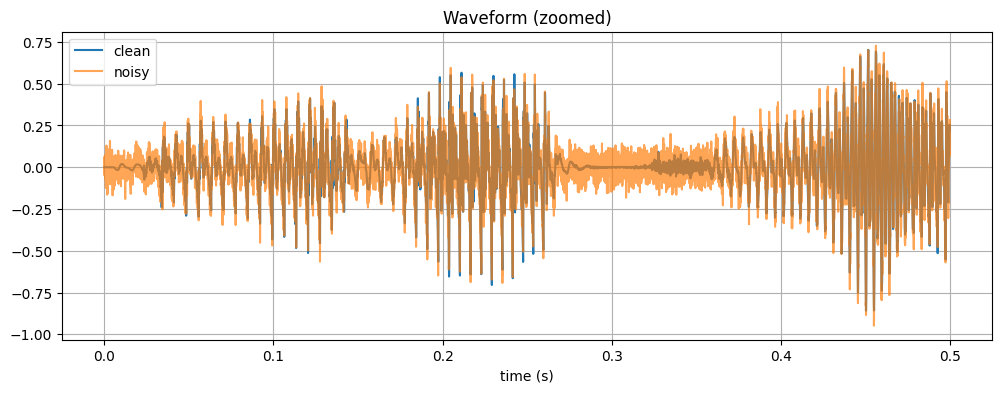

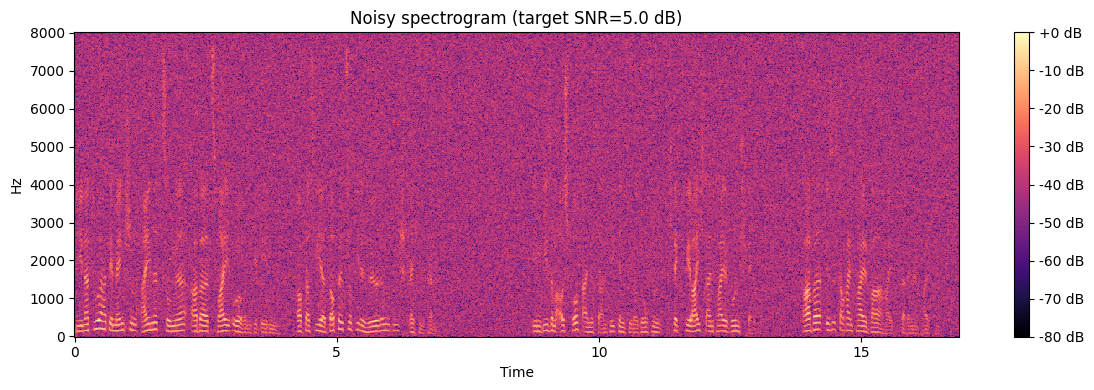

In [15]:
def plot_waveforms(clean, noisy, sr, seconds=0.05):
    n = int(seconds*sr)
    t = np.arange(n)/sr
    plt.figure(figsize=(12,4))
    plt.plot(t, clean[:n], label='clean')
    plt.plot(t, noisy[:n], label='noisy', alpha=0.7)
    plt.xlabel('time (s)')
    plt.title('Waveform (zoomed)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_waveforms(x, y, sr, seconds=0.5)

def plot_spectrogram(sig, sr, title):
    S = np.abs(librosa.stft(sig, n_fft=1024, hop_length=256))
    SdB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(12,4))
    librosa.display.specshow(SdB, sr=sr, hop_length=256, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

import librosa.display
plot_spectrogram(y, sr, f'Noisy spectrogram (target SNR={SNR_TARGET_DB} dB)')

# 4) Predictive denoising: Blockwise LPC

### Principle
We model the signal as predictable from its past samples:

\[
\hat{x}[n] = -\sum_{k=1}^{p} a_k x[n-k]
\]

For speech/audio, the short-term structure is often predictable. White noise is much less predictable, so the **prediction output** tends to emphasize the clean component.

Implementation approach:
- Estimate LPC coefficients per short block (e.g. 20–40 ms)
- Do **one-step prediction** inside each block
- Use predicted signal as the denoised output

Notes:
- This is a simple baseline predictor-denoiser; for some signals (music, transients) it may smear attacks.
- If noise is *colored* (predictable), performance can drop.


In [16]:
def levinson_durbin(r: np.ndarray, order: int):
    """Levinson-Durbin recursion.
    Returns LPC coeffs a (length order+1, a[0]=1) and prediction error power.
    """
    # r[0..order]
    a = np.zeros(order+1, dtype=np.float64)
    e = float(r[0])
    a[0] = 1.0
    if e <= 1e-12:
        return a, 0.0

    for i in range(1, order+1):
        acc = 0.0
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k = -(r[i] + acc) / (e + 1e-12)

        a_new = a.copy()
        a_new[i] = k
        for j in range(1, i):
            a_new[j] = a[j] + k * a[i-j]
        a = a_new
        e *= (1.0 - k*k)
        if e < 0:
            e = 0.0
    return a, float(e)

def lpc_predict_blockwise(sig: np.ndarray, order: int = 16, frame_len: int = 512, hop: int = 256):
    """Blockwise LPC one-step prediction. Returns predicted ("denoised") signal."""
    sig = sig.astype(np.float64)
    N = len(sig)
    out = np.zeros(N, dtype=np.float64)
    win = np.hanning(frame_len).astype(np.float64)
    wsum = np.zeros(N, dtype=np.float64)

    for start in range(0, N - frame_len + 1, hop):
        frame = sig[start:start+frame_len].copy()
        frame_w = frame * win
        # autocorrelation up to order
        r = np.array([np.dot(frame_w[:frame_len-k], frame_w[k:]) for k in range(order+1)], dtype=np.float64)
        a, _ = levinson_durbin(r, order)

        # one-step prediction: xhat[n] = -sum_{k=1..p} a[k] * x[n-k]
        xhat = np.zeros(frame_len, dtype=np.float64)
        for n in range(frame_len):
            acc = 0.0
            for k in range(1, order+1):
                if n-k >= 0:
                    acc += a[k] * frame[n-k]
            xhat[n] = -acc

        # overlap-add (windowed)
        out[start:start+frame_len] += xhat * win
        wsum[start:start+frame_len] += win

    out = out / (wsum + 1e-12)
    # fallback for edges not covered
    out[:frame_len//2] = out[frame_len//2]
    out[-frame_len//2:] = out[-frame_len//2-1]
    # normalize to avoid clipping
    out = out / (np.max(np.abs(out)) + 1e-12)
    return out.astype(np.float32)

LPC_ORDER = 16
FRAME_MS = 32
frame_len = int(sr * FRAME_MS / 1000)
frame_len = max(256, int(2**np.ceil(np.log2(frame_len))))  # power of 2, >=256
hop = frame_len // 2

xhat_lpc = lpc_predict_blockwise(y, order=LPC_ORDER, frame_len=frame_len, hop=hop)

print('Input SNR (dB): ', snr_db(x, y))
print('LPC-pred SNR (dB):', snr_db(x, xhat_lpc))

display(Audio(xhat_lpc, rate=sr))

Input SNR (dB):  5.000000398954811
LPC-pred SNR (dB): 8.32427654750965


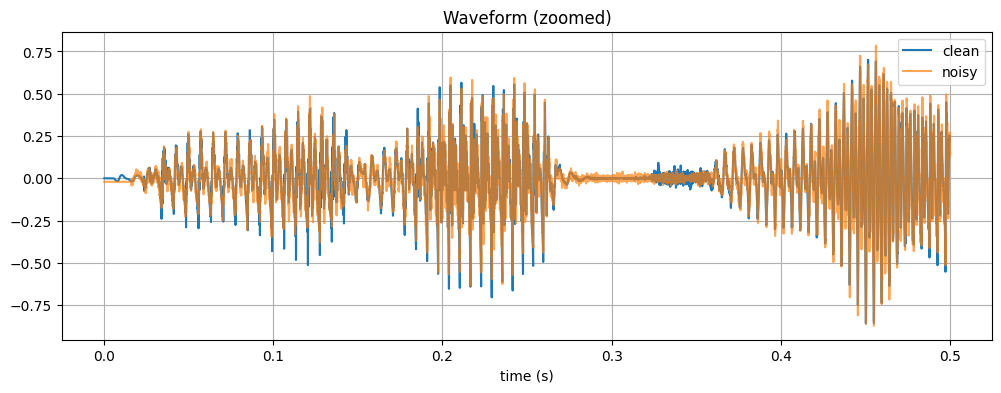

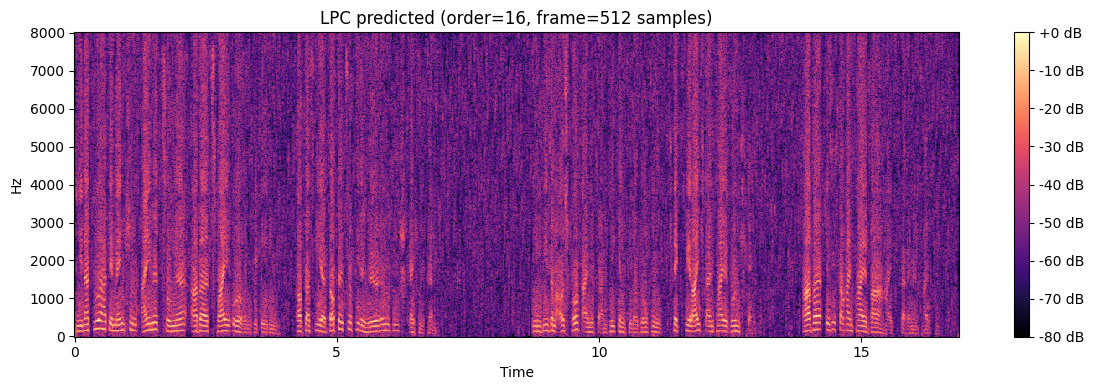

In [20]:
plot_waveforms(x, xhat_lpc, sr, seconds=0.5)
plot_spectrogram(xhat_lpc, sr, f'LPC predicted (order={LPC_ORDER}, frame={frame_len} samples)')

# 5) Predictive denoising: Adaptive LMS predictor

### Principle
We adapt filter weights online to minimize the prediction error:

- Predictor input vector: **past samples** $\mathbf{u}[n] = [y[n-1],\dots,y[n-p]]^T$
- Prediction: $\hat{y}[n] = \mathbf{w}^T[n]\mathbf{u}[n]$
- Error: $e[n] = y[n] - \hat{y}[n]$
- Update: $\mathbf{w}[n+1] = \mathbf{w}[n] + 2\mu e[n]\mathbf{u}[n]$

For denoising, we take **$\hat{y}[n]$** as the estimate of the predictable (clean-ish) part.

Tuning tips:
- Increase order for more modeling power (speech often uses 8–20)
- Decrease step size $\mu$ if it gets unstable / distorted


In [18]:
def lms_predict(sig: np.ndarray, order: int = 16, mu: float = 0.01, normalize: bool = True):
    """One-step LMS predictor. Returns predicted signal xhat and error e."""
    sig = sig.astype(np.float64)
    N = len(sig)
    w = np.zeros(order, dtype=np.float64)
    xhat = np.zeros(N, dtype=np.float64)
    e = np.zeros(N, dtype=np.float64)

    for n in range(order, N):
        u = sig[n-order : n][::-1]  # [sig[n-1],...,sig[n-order]] - Fixed slicing
        yhat = np.dot(w, u)
        xhat[n] = yhat
        err = sig[n] - yhat
        e[n] = err
        if normalize:
            # Normalized LMS-like step: mu / (||u||^2 + eps)
            denom = np.dot(u, u) + 1e-6
            w = w + (mu / denom) * err * u
        else:
            w = w + 2.0 * mu * err * u

    xhat[:order] = xhat[order]
    # normalize output to prevent clipping
    xhat = xhat / (np.max(np.abs(xhat)) + 1e-12)
    return xhat.astype(np.float32), e.astype(np.float32)

LMS_ORDER = 16
MU = 0.05  # if unstable/distorted: try 0.01 or 0.005
xhat_lms, e_lms = lms_predict(y, order=LMS_ORDER, mu=MU, normalize=True)

print('Input SNR (dB): ', snr_db(x, y))
print('LMS-pred SNR (dB):', snr_db(x, xhat_lms))

display(Audio(xhat_lms, rate=sr))

Input SNR (dB):  5.000000398954811
LMS-pred SNR (dB): 6.827865609128199


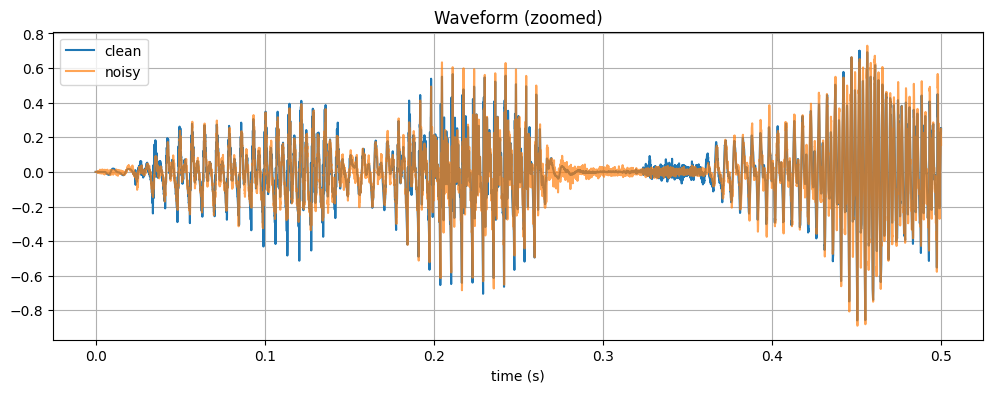

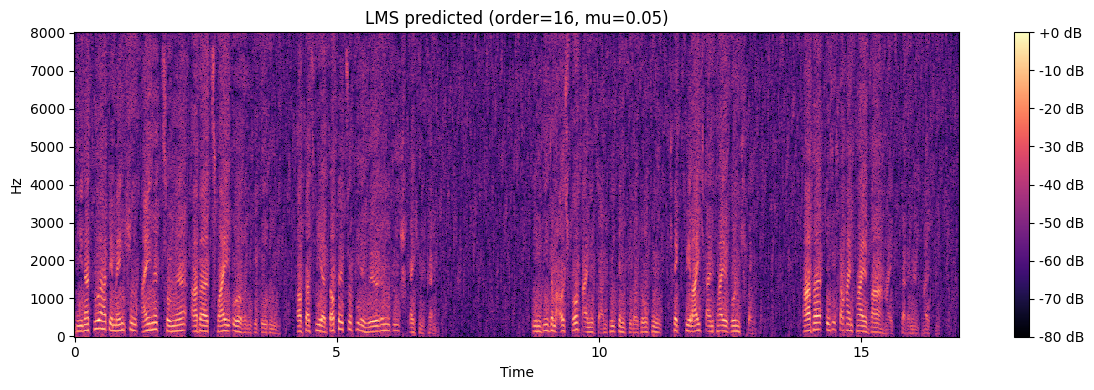

In [19]:
plot_waveforms(x, xhat_lms, sr, seconds=0.5)
plot_spectrogram(xhat_lms, sr, f'LMS predicted (order={LMS_ORDER}, mu={MU})')

## 6) Compare outputs + save WAV files


In [21]:
print('Measured SNRs:')
print('  noisy    :', snr_db(x, y))
print('  LPC pred :', snr_db(x, xhat_lpc))
print('  LMS pred :', snr_db(x, xhat_lms))

# Save
sf.write('clean.wav', x, sr)
sf.write('noisy.wav', y, sr)
sf.write('denoised_lpc.wav', xhat_lpc, sr)
sf.write('denoised_lms.wav', xhat_lms, sr)
print('Wrote: clean.wav, noisy.wav, denoised_lpc.wav, denoised_lms.wav')

from google.colab import files
files.download('noisy.wav')
files.download('denoised_lpc.wav')
files.download('denoised_lms.wav')

Measured SNRs:
  noisy    : 5.000000398954811
  LPC pred : 8.32427654750965
  LMS pred : 6.827865609128199
Wrote: clean.wav, noisy.wav, denoised_lpc.wav, denoised_lms.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7) Suggested experiments

Try:
- Different SNR targets: 0 / 5 / 10 / 20 dB
- LPC order: 8, 12, 16, 24
- Frame length: 20–40 ms
- LMS step size μ: 0.005–0.1 (smaller is safer)

Observe:
- Speech tends to improve more than music
- Too-high order/μ can cause artifacts or instability
- Colored noise (predictable) is harder to suppress with prediction-only
